In [ ]:
##Import Library
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2023-07-07 13:12:29.847969: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 13:12:29.900561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 13:12:30.754400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Pre-Setting

In [ ]:
random.seed(7777)
# Set paths and parameters
data_dir = "C:\\Users\\Lee Xun\\iCloudDrive\\Documents_\\Study\\Sem 4\\CDS521\\Assignment 2\\Resized Image_Inceptionv3"
train_dir = '/home/ubuntu/Image/Split/train'
valid_dir = '/home/ubuntu/Image/Split/val'
test_dir = '/home/ubuntu/Image/Split/test'
split_ratio = (0.6, 0.2, 0.2)
input_shape = (299, 299)  # InceptionV3 input shape
batch_size = 32
num_classes = 3

# Create the directories for train, valid, and test splits
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over the subdirectories in the data directory
for sub_dir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        # Create corresponding subdirectories in train, valid, and test splits
        train_sub_dir = os.path.join(train_dir, sub_dir)
        valid_sub_dir = os.path.join(valid_dir, sub_dir)
        test_sub_dir = os.path.join(test_dir, sub_dir)
        os.makedirs(train_sub_dir, exist_ok=True)
        os.makedirs(valid_sub_dir, exist_ok=True)
        os.makedirs(test_sub_dir, exist_ok=True)
        
        # Get the list of images in the current subdirectory
        images = os.listdir(sub_dir_path)
        random.shuffle(images)
        
        # Calculate the number of images for each split
        num_images = len(images)
        num_train = int(num_images * split_ratio[0])
        num_valid = int(num_images * split_ratio[1])
        num_test = num_images - num_train - num_valid
        
        # Split the images into train, valid, and test sets
        train_images = images[:num_train]
        valid_images = images[num_train:num_train+num_valid]
        test_images = images[num_train+num_valid:]
        
        # Move the images to the corresponding directories
        for image in train_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(train_sub_dir, image)
            shutil.copyfile(src, dst)
        
        for image in valid_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(valid_sub_dir, image)
            shutil.copyfile(src, dst)
        
        for image in test_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(test_sub_dir, image)
            shutil.copyfile(src, dst)


In [ ]:
# Get the list of class names by excluding the .ipynb_checkpoints directory
class_names = [name for name in os.listdir(train_dir) if name != '.ipynb_checkpoints']
class_names

['Parking Lot', 'Harbor', 'Container']

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    seed=7777,
    classes=class_names
)

Found 4687 images belonging to 3 classes.


In [ ]:
# Validation data generator
valid_generator = train_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    seed=7777,
    classes=class_names
)

Found 1562 images belonging to 3 classes.


In [ ]:
# Test data generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    seed=7777,
    classes=class_names
)

Found 1564 images belonging to 3 classes.


Train model with different dense

In [ ]:
# Create the InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
base_model.trainable = False

2023-07-07 13:12:37.756342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 13:12:37.797062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 13:12:37.798747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
dense = ["256", "512", "1024", "2048"]
learningrate = 0.0001
epochs_values = 1

train_accuracy_list =[]
train_loss_list =[]
val_accuracy_list = []
val_loss_list = []
test_accuracy_list =[]
test_loss_list = []

for i in dense:
    print("Current dense is " + str(i))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(i, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model_diff_dense = Model(inputs=base_model.input, outputs=outputs)

    model_diff_dense.compile( tf.keras.optimizers.Adam(learning_rate=learningrate),
                                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                 metrics=['accuracy'])
    train_history = model_diff_dense.fit(train_generator,
                             epochs =epochs_values,
                             validation_data=valid_generator)
    test_loss, test_acc = model_diff_dense.evaluate(test_generator)

    print('Test accuracy for ', i,":" , test_acc)

    train_accuracy_list.append(train_history.history['accuracy'])
    train_loss_list.append(train_history.history['loss'])
    val_accuracy_list.append(train_history.history['val_accuracy'])
    val_loss_list.append(train_history.history['val_loss'])
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)




Current dense is 256


2023-07-07 11:09:01.838968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-07 11:09:05.943473: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2167d1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 11:09:05.943507: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-07 11:09:06.015929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-07 11:09:06.510337: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of

147/147 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9164

2023-07-07 11:10:33.151912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 123s 810ms/step - loss: 0.2665 - accuracy: 0.9164 - val_loss: 0.1113 - val_accuracy: 0.9661


2023-07-07 11:11:05.762195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 31s 630ms/step - loss: 0.1012 - accuracy: 0.9712
Test accuracy for  256 : 0.9712276458740234
Current dense is 512


2023-07-07 11:11:37.340375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9281

2023-07-07 11:13:05.180178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 117s 768ms/step - loss: 0.2162 - accuracy: 0.9281 - val_loss: 0.1210 - val_accuracy: 0.9673


2023-07-07 11:13:34.918520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 567ms/step - loss: 0.1049 - accuracy: 0.9680
Test accuracy for  512 : 0.9680306911468506
Current dense is 1024


2023-07-07 11:14:03.526107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9452

2023-07-07 11:15:30.888415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 765ms/step - loss: 0.1710 - accuracy: 0.9452 - val_loss: 0.0841 - val_accuracy: 0.9750


2023-07-07 11:16:00.454294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 576ms/step - loss: 0.0722 - accuracy: 0.9783
Test accuracy for  1024 : 0.97826087474823
Current dense is 2048


2023-07-07 11:16:29.490440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9377

2023-07-07 11:17:56.927087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 117s 771ms/step - loss: 0.1804 - accuracy: 0.9377 - val_loss: 0.0816 - val_accuracy: 0.9725


2023-07-07 11:18:27.246023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 571ms/step - loss: 0.0708 - accuracy: 0.9789
Test accuracy for  2048 : 0.9789002537727356


In [ ]:
train_accuracy = [sublist[-1] for sublist in train_accuracy_list ]
train_loss = [sublist[-1] for sublist in train_loss_list ]
val_accuracy = [sublist[-1] for sublist in val_accuracy_list ]
val_loss = [sublist[-1] for sublist in val_loss_list ]


In [ ]:
result_diff_dense = pd.DataFrame({"Dense" : dense,"Train Accuracy" : train_accuracy, "Train Loss" : train_loss, "Validation Accuracy": val_accuracy, "Validation Loss": val_loss, "Test Accuracy": test_accuracy_list, "Test Loss": test_loss_list})
result_diff_dense

,Dense,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
0,256,0.916364,0.266466,0.966069,0.111332,0.971228,0.101194
1,512,0.928099,0.216191,0.967350,0.121035,0.968031,0.104870
2,1024,0.945167,0.170950,0.975032,0.084080,0.978261,0.072244
3,2048,0.937700,0.180387,0.972471,0.081643,0.978900,0.070824


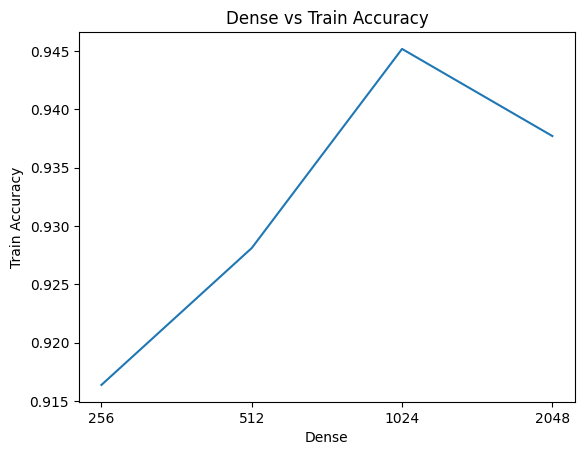

In [ ]:
dense = result_diff_dense["Dense"]
train_accuracy = result_diff_dense["Train Accuracy"].astype(float)

# Plot the line chart
plt.plot(dense, train_accuracy)
plt.xlabel("Dense")
plt.ylabel("Train Accuracy")
plt.title("Dense vs Train Accuracy")
plt.show()

Train Model with different Optimizer

In [ ]:
# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [ ]:
learningrate = 0.0001
epochs_values = 1
optimzers = [tf.keras.optimizers.Adam(learning_rate=learningrate),
            tf.keras.optimizers.RMSprop(learning_rate=learningrate),
            tf.keras.optimizers.SGD(learning_rate=learningrate),
            tf.keras.optimizers.Adadelta(learning_rate=learningrate),
            tf.keras.optimizers.Adagrad(learning_rate=learningrate),
            tf.keras.optimizers.Adamax(learning_rate=learningrate),
            tf.keras.optimizers.Nadam(learning_rate=learningrate)]

optmizer_list =["Adam","RMSprop","SGD","Adadelta","Adagrad","Adamax","Nadam"]
train_accuracy_list =[]
train_loss_list =[]
val_accuracy_list = []
val_loss_list = []
test_accuracy_list =[]
test_loss_list = []

for i, j in zip(optimzers, optmizer_list):
    print("Current Optimizer is " + j)
    model_diff_optimizer = Model(inputs=base_model.input, outputs=outputs)
    model_diff_optimizer.compile( optimizer = i,
                                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                 metrics=['accuracy'])
    train_history = model_diff_optimizer.fit(train_generator,
                             epochs =epochs_values,
                             validation_data=valid_generator)
    test_loss, test_acc = model_diff_optimizer.evaluate(test_generator)

    print('Test accuracy for ', j,":" , test_acc)

    train_accuracy_list.append(train_history.history['accuracy'])
    train_loss_list.append(train_history.history['loss'])
    val_accuracy_list.append(train_history.history['val_accuracy'])
    val_loss_list.append(train_history.history['val_loss'])
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)


Current Optimizer is Adam


2023-07-07 12:35:21.584185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9789

2023-07-07 12:36:48.930056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 766ms/step - loss: 0.0563 - accuracy: 0.9789 - val_loss: 0.0509 - val_accuracy: 0.9814


2023-07-07 12:37:18.413999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 564ms/step - loss: 0.0438 - accuracy: 0.9840
Test accuracy for  Adam : 0.9840153455734253
Current Optimizer is RMSprop


2023-07-07 12:37:46.817534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9859

2023-07-07 12:39:17.417433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 120s 792ms/step - loss: 0.0444 - accuracy: 0.9859 - val_loss: 0.0643 - val_accuracy: 0.9802


2023-07-07 12:39:47.230205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 567ms/step - loss: 0.0495 - accuracy: 0.9827
Test accuracy for  RMSprop : 0.9827365875244141
Current Optimizer is SGD


2023-07-07 12:40:16.587639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9836

2023-07-07 12:41:42.133769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 115s 756ms/step - loss: 0.0470 - accuracy: 0.9836 - val_loss: 0.0590 - val_accuracy: 0.9795


2023-07-07 12:42:11.760040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 564ms/step - loss: 0.0357 - accuracy: 0.9885
Test accuracy for  SGD : 0.9884910583496094
Current Optimizer is Adadelta


2023-07-07 12:42:40.161011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9863

2023-07-07 12:44:05.332460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 114s 751ms/step - loss: 0.0383 - accuracy: 0.9863 - val_loss: 0.0594 - val_accuracy: 0.9814


2023-07-07 12:44:34.784342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 27s 553ms/step - loss: 0.0435 - accuracy: 0.9866
Test accuracy for  Adadelta : 0.9865728616714478
Current Optimizer is Adagrad


2023-07-07 12:45:02.636835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9844

2023-07-07 12:46:28.667021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 115s 756ms/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.0460 - val_accuracy: 0.9853


2023-07-07 12:46:57.810719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 27s 551ms/step - loss: 0.0483 - accuracy: 0.9834
Test accuracy for  Adagrad : 0.9833759665489197
Current Optimizer is Adamax


2023-07-07 12:47:25.562848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9887

2023-07-07 12:48:52.700317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 117s 772ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0560 - val_accuracy: 0.9776


2023-07-07 12:49:23.177419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 559ms/step - loss: 0.0341 - accuracy: 0.9879
Test accuracy for  Adamax : 0.9878516793251038
Current Optimizer is Nadam


2023-07-07 12:49:51.345270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9861

2023-07-07 12:51:18.948932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [ ]:
train_accuracy = [sublist[-1] for sublist in train_accuracy_list ]
train_loss = [sublist[-1] for sublist in train_loss_list ]
val_accuracy = [sublist[-1] for sublist in val_accuracy_list ]
val_loss = [sublist[-1] for sublist in val_loss_list ]


In [ ]:
result_diff_optimizer = pd.DataFrame({"Optimizers" : optmizer_list,"Train Accuracy" : train_accuracy, "Train Loss" : train_loss, "Validation Accuracy": val_accuracy, "Validation Loss": val_loss, "Test Accuracy": test_accuracy_list, "Test Loss": test_loss_list})
result_diff_optimizer

,Optimizers,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
0,Adam,0.937487,0.136511,0.975672,0.064406,0.979540,0.055586
1,RMSprop,0.976958,0.055636,0.983995,0.050447,0.981458,0.046162
2,SGD,0.979518,0.044361,0.982074,0.050875,0.985294,0.038436
3,Adadelta,0.986132,0.041746,0.983355,0.048562,0.986573,0.040326
4,Adagrad,0.985065,0.042244,0.978873,0.049382,0.984015,0.042135
5,Adamax,0.983572,0.041733,0.980154,0.044338,0.984655,0.036725
6,Nadam,0.983572,0.039015,0.983995,0.040378,0.988491,0.031824


Train model with different learning rate

In [ ]:
learningrate_list = [0.1,0.01,0.001,0.0001]
epochs_values = 1

train_accuracy_list =[]
train_loss_list =[]
val_accuracy_list = []
val_loss_list = []
test_accuracy_list =[]
test_loss_list = []

for i in learningrate_list:
    print("Current learning rate is " + str(i))
    model_diff_learningrate = Model(inputs=base_model.input, outputs=outputs)

    model_diff_learningrate.compile( optimizer = tf.keras.optimizers.Adadelta(learning_rate=i ),
                                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                 metrics=['accuracy'])
    train_history = model_diff_learningrate.fit(train_generator,
                             epochs =epochs_values,
                             validation_data=valid_generator)
    test_loss, test_acc = model_diff_learningrate.evaluate(test_generator)

    print('Test accuracy for ', i,":" , test_acc)

    train_accuracy_list.append(train_history.history['accuracy'])
    train_loss_list.append(train_history.history['loss'])
    val_accuracy_list.append(train_history.history['val_accuracy'])
    val_loss_list.append(train_history.history['val_loss'])
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)

Current learning rate is 0.1


2023-07-07 13:14:41.096097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/ubuntu/.local/lib/python3.8/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-07 13:14:46.070320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-07 13:14:49.160017: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2040eb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 13:14:49.160048: I tensorflow/compiler/xla/service/service.c

147/147 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9304

2023-07-07 13:16:13.297804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 123s 784ms/step - loss: 0.2223 - accuracy: 0.9304 - val_loss: 0.0967 - val_accuracy: 0.9680


2023-07-07 13:16:44.760287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 30s 608ms/step - loss: 0.0853 - accuracy: 0.9776
Test accuracy for  0.1 : 0.9776214957237244
Current learning rate is 0.01


2023-07-07 13:17:15.272735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9763

2023-07-07 13:18:42.641949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 765ms/step - loss: 0.0862 - accuracy: 0.9763 - val_loss: 0.0800 - val_accuracy: 0.9795


2023-07-07 13:19:12.123667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 565ms/step - loss: 0.0715 - accuracy: 0.9821
Test accuracy for  0.01 : 0.9820972084999084
Current learning rate is 0.001


2023-07-07 13:19:40.561822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9799

2023-07-07 13:21:07.738277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 766ms/step - loss: 0.0761 - accuracy: 0.9799 - val_loss: 0.0902 - val_accuracy: 0.9744


2023-07-07 13:21:37.335572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 565ms/step - loss: 0.0773 - accuracy: 0.9763
Test accuracy for  0.001 : 0.9763427376747131
Current learning rate is 0.0001


2023-07-07 13:22:05.804257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9785

2023-07-07 13:23:33.156974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 764ms/step - loss: 0.0816 - accuracy: 0.9785 - val_loss: 0.0853 - val_accuracy: 0.9731


2023-07-07 13:24:02.614900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 565ms/step - loss: 0.0740 - accuracy: 0.9834
Test accuracy for  0.0001 : 0.9833759665489197


In [ ]:
train_accuracy = [sublist[-1] for sublist in train_accuracy_list ]
train_loss = [sublist[-1] for sublist in train_loss_list ]
val_accuracy = [sublist[-1] for sublist in val_accuracy_list ]
val_loss = [sublist[-1] for sublist in val_loss_list ]


In [ ]:
result_diff_learningrate= pd.DataFrame({"Learning Rate" : learningrate_list,"Train Accuracy" : train_accuracy, "Train Loss" : train_loss, "Validation Accuracy": val_accuracy, "Validation Loss": val_loss, "Test Accuracy": test_accuracy_list, "Test Loss": test_loss_list})
result_diff_learningrate

,Learning Rate,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
0,0.1000,0.930446,0.222311,0.967990,0.096712,0.977621,0.085274
1,0.0100,0.976317,0.086166,0.979513,0.080038,0.982097,0.071539
2,0.0010,0.979945,0.076086,0.974392,0.090208,0.976343,0.077283
3,0.0001,0.978451,0.081636,0.973111,0.085340,0.983376,0.073998


Train with layer lock/unlock

In [ ]:
layer = [True, False]
epochs_values = 1

train_accuracy_list =[]
train_loss_list =[]
val_accuracy_list = []
val_loss_list = []
test_accuracy_list =[]
test_loss_list = []

for i in layer:
    print("Current Layer is " + str(i))
    base_model.trainable = i
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model_diff_layer = Model(inputs=base_model.input, outputs=output)

    model_diff_layer.compile( optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001),
                                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                 metrics=['accuracy'])
    train_history = model_diff_layer.fit(train_generator,
                             epochs =epochs_values,
                             validation_data=valid_generator)
    test_loss, test_acc = model_diff_layer.evaluate(test_generator)

    print('Test accuracy for ', i,":" , test_acc)

    train_accuracy_list.append(train_history.history['accuracy'])
    train_loss_list.append(train_history.history['loss'])
    val_accuracy_list.append(train_history.history['val_accuracy'])
    val_loss_list.append(train_history.history['val_loss'])
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)

Current Layer is True


2023-07-07 13:27:00.753169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/ubuntu/.local/lib/python3.8/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


147/147 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.5692

2023-07-07 13:29:02.986379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 151s 791ms/step - loss: 0.9803 - accuracy: 0.5692 - val_loss: 0.8145 - val_accuracy: 0.8015


2023-07-07 13:29:32.447046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 566ms/step - loss: 0.8153 - accuracy: 0.7896
Test accuracy for  True : 0.7896419167518616
Current Layer is False


2023-07-07 13:30:00.971462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.4728

2023-07-07 13:31:27.927245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 116s 765ms/step - loss: 1.0457 - accuracy: 0.4728 - val_loss: 0.9795 - val_accuracy: 0.5717


2023-07-07 13:31:57.689851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 567ms/step - loss: 0.9897 - accuracy: 0.5332
Test accuracy for  False : 0.5332480669021606


In [ ]:
train_accuracy = [sublist[-1] for sublist in train_accuracy_list ]
train_loss = [sublist[-1] for sublist in train_loss_list ]
val_accuracy = [sublist[-1] for sublist in val_accuracy_list ]
val_loss = [sublist[-1] for sublist in val_loss_list ]


In [ ]:
result_diff_layer= pd.DataFrame({"Layer" : layer,"Train Accuracy" : train_accuracy, "Train Loss" : train_loss, "Validation Accuracy": val_accuracy, "Validation Loss": val_loss, "Test Accuracy": test_accuracy_list, "Test Loss": test_loss_list})
result_diff_layer

,Layer,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
0,True,0.569234,0.980256,0.801537,0.814466,0.789642,0.815337
1,False,0.472797,1.045668,0.571703,0.979541,0.533248,0.989720


Train with higher epoch

In [ ]:
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

final_model = Model(inputs=base_model.input, outputs=output)

final_model.compile( optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001),
                                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                metrics=['accuracy'])
train_history = final_model.fit(train_generator,
                            epochs = 20,
                            validation_data=valid_generator)
test_loss, test_acc = final_model.evaluate(test_generator)

print('Test accuracy :' , test_acc)

Epoch 1/20


2023-07-07 13:40:03.341195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.7246

2023-07-07 13:41:55.683533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


147/147 [==============================] - 141s 770ms/step - loss: 0.8488 - accuracy: 0.7246 - val_loss: 0.5759 - val_accuracy: 0.9545
Epoch 2/20
147/147 [==============================] - 111s 757ms/step - loss: 0.4579 - accuracy: 0.9595 - val_loss: 0.3171 - val_accuracy: 0.9770
Epoch 3/20
147/147 [==============================] - 111s 756ms/step - loss: 0.2862 - accuracy: 0.9695 - val_loss: 0.1994 - val_accuracy: 0.9802
Epoch 4/20
147/147 [==============================] - 112s 759ms/step - loss: 0.2052 - accuracy: 0.9695 - val_loss: 0.1401 - val_accuracy: 0.9840
Epoch 5/20
147/147 [==============================] - 113s 769ms/step - loss: 0.1618 - accuracy: 0.9691 - val_loss: 0.1078 - val_accuracy: 0.9834
Epoch 6/20
147/147 [==============================] - 111s 756ms/step - loss: 0.1296 - accuracy: 0.9759 - val_loss: 0.0919 - val_accuracy: 0.9872
Epoch 7/20
147/147 [==============================] - 111s 755ms/step - loss: 0.1112 - accuracy: 0.9757 - val_loss: 0.0754 - val_accura

2023-07-07 14:17:43.947428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 565ms/step - loss: 0.0290 - accuracy: 0.9930
Test accuracy : 0.9929667711257935


In [ ]:
final_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

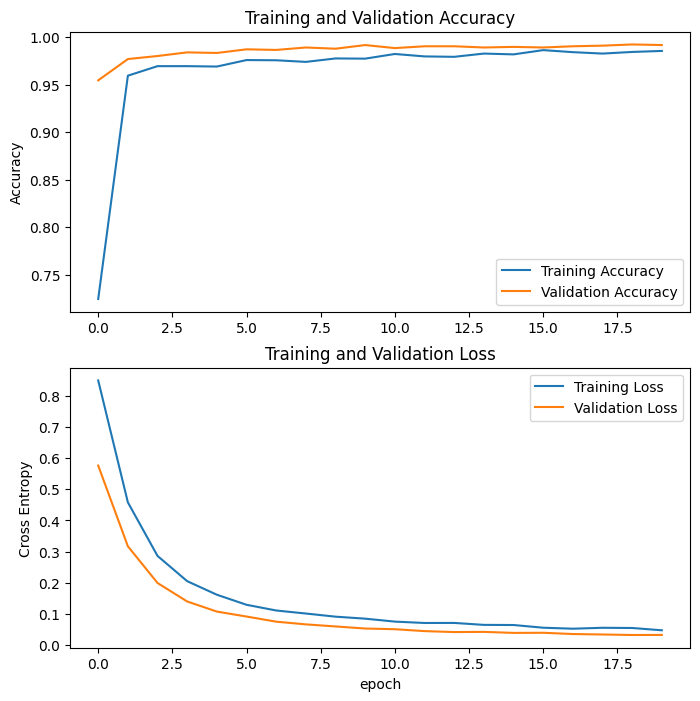

In [ ]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
predictions = final_model.predict(test_generator)

2023-07-07 14:19:42.464538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 28s 559ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
print(test_generator.classes)

[0 0 0 ... 2 2 2]


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Parking Lot
1 : Harbor
2 : Container
